In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Setup

In [38]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic



# Define outut folder for plot data
plot_data_dir = f"plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 100
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"
ONE_SIDED = True


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"
feature_set = ["dimu_pt", "mu0_ip3d", "mu1_ip3d"]


train_samesign = False


# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

data_prefix = f"{project_id}_{particle_type}{train_data_id}_{jet_id}"

In [10]:
with open(f"{plot_data_dir}{data_prefix}_SR_SB.pickle", "rb") as file:
    SR, SB = pickle.load(file)
    SB_left, SB_right = SB
    SR_left, SR_right = SR

print(f"SR: {SR_left}, {SR_right}")
print(f"SB: {SB_left}, {SB_right}")

SR: 9.0, 10.6
SB: 7.8, 14.0


# Cut Histograms

In [36]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)


def plot_histograms_with_fits(save_data, SB_left, SR_left, SR_right, SB_right, title = None, upsilon_lines = True):
    
    fpr_thresholds = save_data["fpr_thresholds"]
    fit_type = save_data["fit_type"]
    num_bins_SR = save_data["num_bins_SR"]
    popts = save_data["popts"]
    pcovs = save_data["pcovs"]
    significances = save_data["significances"]
    filtered_masses = save_data["filtered_masses"]
    y_vals = save_data["y_vals"]


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses_t = filtered_masses[t]
        popt = popts[t]
        pcov = pcovs[t]
        total_events = len(filtered_masses_t)
        significance = significances[t]
        y_vals_t = y_vals[t]

        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

        # plot the data
        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(significance,2))
        plt.hist(filtered_masses_t, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals_t, color = f"C{t}")




    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = title
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    if upsilon_lines:
        plot_upsilon_resonances(ax)
        

<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_891559/3576230093.py:82: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


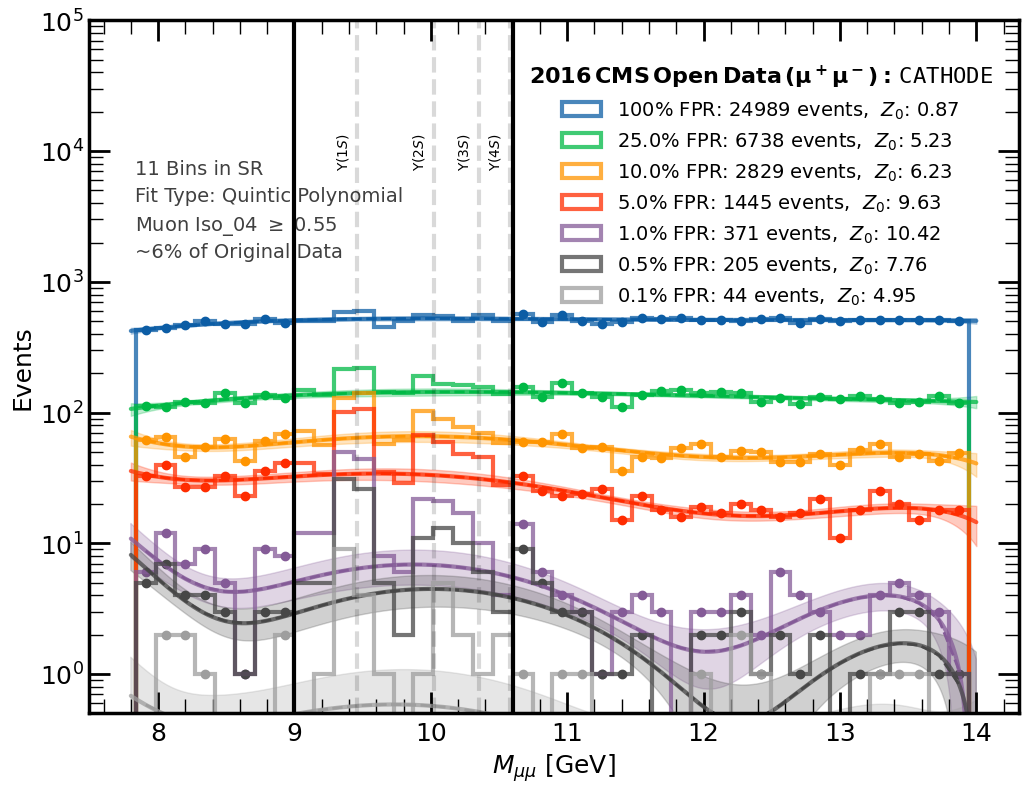

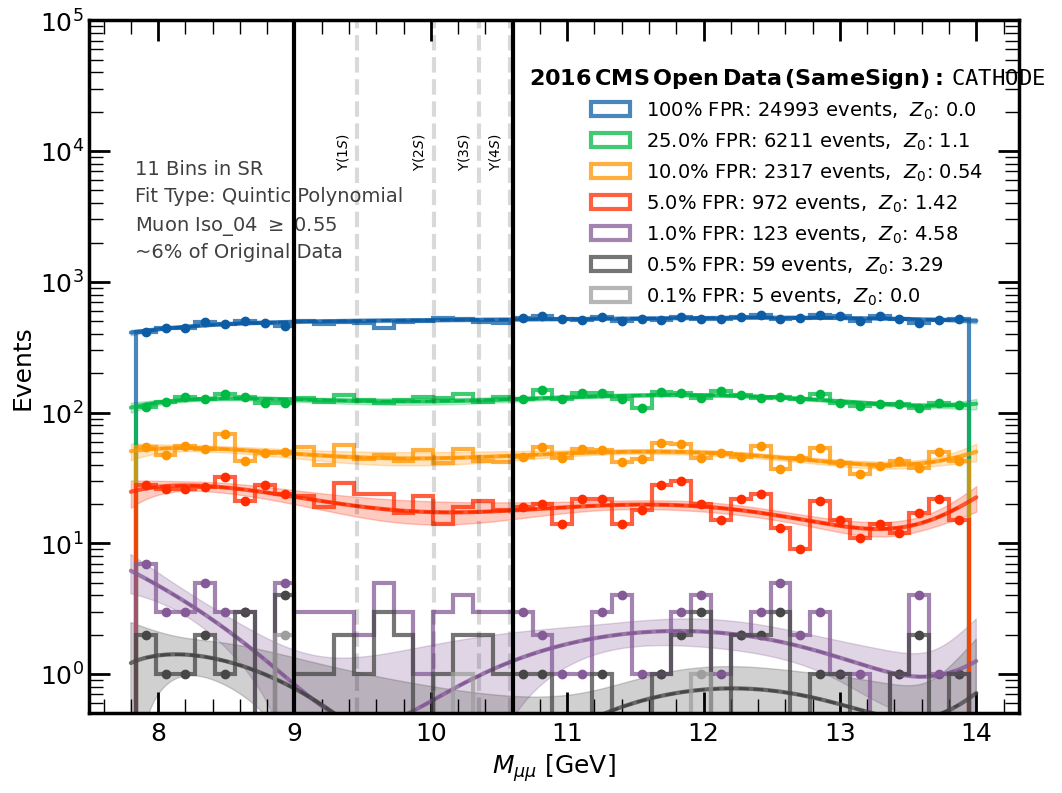

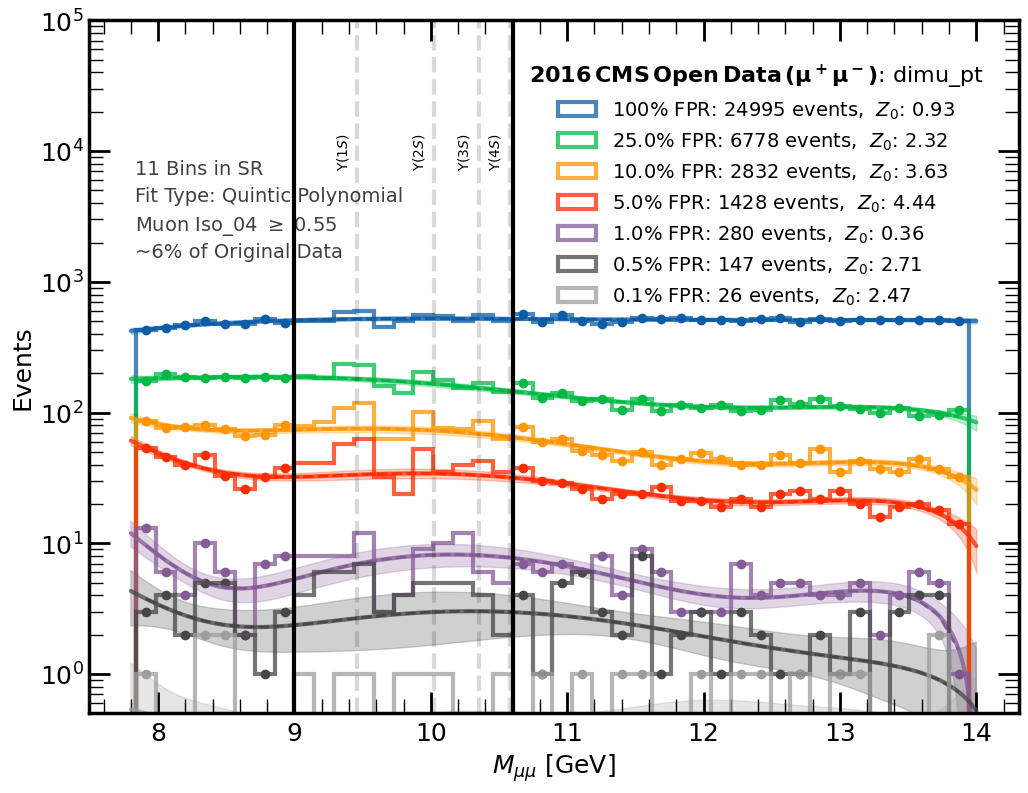

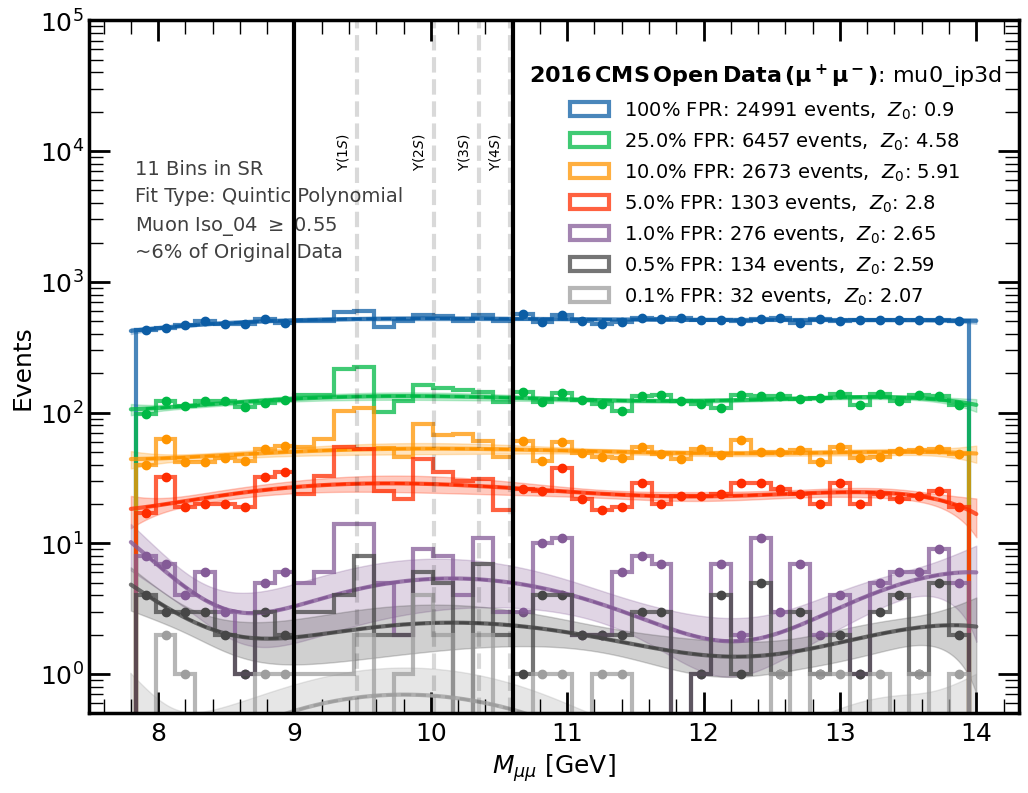

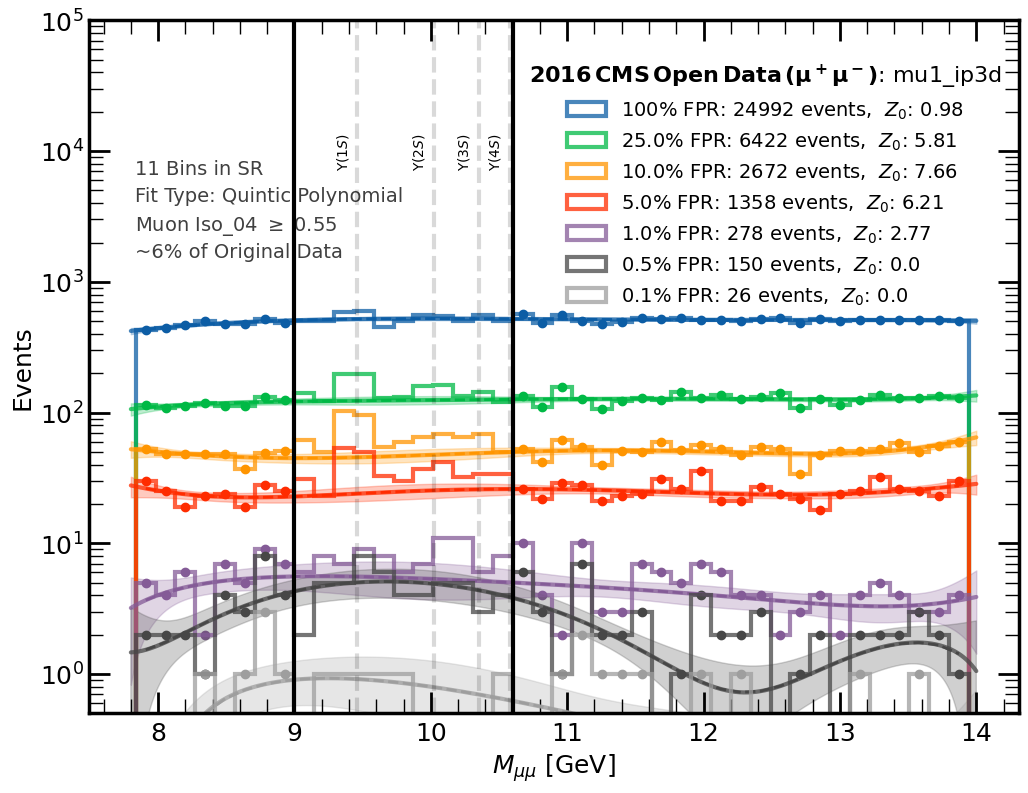

In [42]:
# Plot the CATHODE
with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
    hist_data = pickle.load(file)
plot_histograms_with_fits(hist_data, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\, CMS\, Open\, Data\,(\mu^+\mu^-)}:\,\tt{CATHODE}$", upsilon_lines = True)

# Plot the Same Sign CATHODE
with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
    hist_data_alt = pickle.load(file)
plot_histograms_with_fits(hist_data_alt, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\, CMS\, Open\, Data\,(Same Sign)}:\,\tt{CATHODE}$", upsilon_lines = True)

# Plot the individual features
for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
        hist_data = pickle.load(file)

    plot_histograms_with_fits(hist_data, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\, CMS\, Open\, Data\,(\mu^+\mu^-)}$: " + feature, upsilon_lines = True)


# Significances 

In [45]:
fpr_thresholds_finegrained = np.logspace(-4, 0, 25)[::-1]

feature_sigs = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs[feature] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_significances_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs["CATHODE"] = pickle.load(file)

[ 0.86679477  2.44435328  2.70150536  4.19061212  5.06659668  4.72784897
  6.23297706  8.78834552 10.05562366  9.96256051 10.80439069 12.69147653
 10.41509914  9.06316114  7.6332749   6.99415808  8.47359635  6.21575665
  4.94597917  4.98507544  4.18225204  4.45729748  4.45729748  2.94608023
  2.94608023]


<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\P'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_891559/1763575411.py:29: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
/tmp/ipykernel_891559/1763575411.py:48: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 20.0)

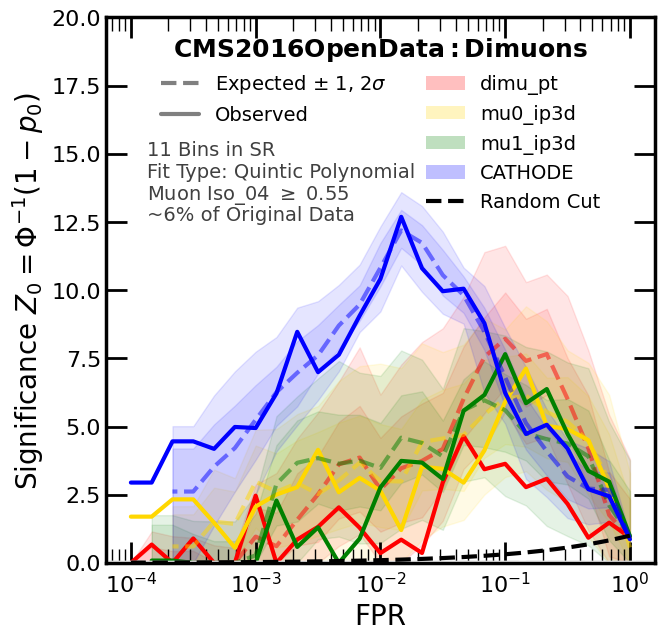

In [46]:
def get_median_percentiles(x_array):
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(feature_sigs.keys()):


    SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_sigs[key][:,1:])
    SIG_observed = feature_sigs[key][:,0]

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

# Artificially make a legend
plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_sigs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(feature_sigs.keys()):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


print(feature_sigs["CATHODE"][:,0])


ax.plot(fpr_thresholds_finegrained, fpr_thresholds_finegrained/np.sqrt(fpr_thresholds_finegrained), linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r"~6% of Original Data"

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 20)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)